In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import folium
from folium.plugins import HeatMap
import seaborn as sns
import contextily as ctx
from folium import Choropleth, GeoJson, GeoJsonTooltip
from folium import IFrame
from branca.element import Template, MacroElement



In [2]:
final_suburb_counts = gpd.read_file("../data/curated/education_df.csv")
primary_schools_df_final = gpd.read_file("../data/raw/primary_school_locations.csv")
final_secondary_schools_df = gpd.read_file("../data/raw/secondary_school_locations.csv")

In [3]:
# Convert rank to numeric (if it's not already)
final_secondary_schools_df['rank'] = pd.to_numeric(final_secondary_schools_df['rank'], errors='coerce')
# Sort the dataframe by rank in ascending order
top_20_secondarys = final_secondary_schools_df.nsmallest(20, 'rank')

In [4]:
# Step 1: Load the shapefile
vic_suburbs = gpd.read_file("../data/map/LOCALITY_POLYGON.shp")
# Rename 'GAZLOC' to gazetted locality
vic_suburbs['suburb'] = vic_suburbs['GAZLOC'].str.lower()
# Filter the dataframe to only include the gazetted localities and their geometries
vic_suburbs_filtered = vic_suburbs[['suburb', 'geometry']]
# Transform the CRS to WGS84 (EPSG:4326)
vic_suburbs_filtered = vic_suburbs_filtered.to_crs(epsg=4326)

heatmap of education density with top 20 secondary schools

In [6]:
# Step 1: Merge geographical data with education counts using an inner join
vic_education_gdf = vic_suburbs_filtered.merge(final_suburb_counts, on='suburb', how='inner')
# Convert 'total_education_count' to numeric
vic_education_gdf['total_education_count'] = pd.to_numeric(vic_education_gdf['total_education_count'], errors='coerce')
# Step 2: Reproject to a projected CRS for accurate area calculation (e.g., VICGRID94)
vic_education_gdf = vic_education_gdf.to_crs(epsg=3111)  # Use a projected CRS like VICGRID94
# Calculate the area in square kilometers (assuming your geometry is in meters)
vic_education_gdf['area_km2'] = vic_education_gdf['geometry'].area / 1e6
# Step 3: Calculate education density (counts of institutions per km²)
vic_education_gdf['education_density'] = vic_education_gdf['total_education_count'] / vic_education_gdf['area_km2']
# Transform back to a geographic CRS for visualization in Folium
vic_education_gdf = vic_education_gdf.to_crs(epsg=4326)

# Create a base map centered on Victoria, Australia
map_victoria = folium.Map(location=[-37.8136, 144.9631], zoom_start=8, tiles="cartodb positron")

# Step 3: Add the choropleth map for education density
choropleth = Choropleth(
    geo_data=vic_education_gdf.__geo_interface__,  # Convert GeoDataFrame to GeoJSON format
    data=vic_education_gdf,                        # DataFrame containing the education density
    columns=['suburb', 'education_density'],       # Columns to map (suburb name and education density)
    key_on='feature.properties.suburb',            # Suburb name from GeoDataFrame
    fill_color='Oranges',                             # Color scheme
    fill_opacity=0.7,                              # Transparency of the color
    line_opacity=0.2,                              # Transparency of the borders
    highlight=True,                                # Enable highlighting on hover
    legend_name='Education Density (institutions per km²)'  # Legend for the map
).add_to(map_victoria)

# Add tooltips to display suburb and education density on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'education_density'],
    aliases=['Suburb:', 'Education Density:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
GeoJson(
    vic_education_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(map_victoria)

# Step 4: Add markers for the top 20 secondary schools
top_secondary_schools = final_secondary_schools_df.nsmallest(20, 'rank')

# Split the top 20 into top 10 and next 10
top_10_secondary_schools = top_secondary_schools.iloc[:10]
next_10_secondary_schools = top_secondary_schools.iloc[10:]

# Add markers for the top 10 secondary schools (red)
for _, row in top_10_secondary_schools.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['school_name'],
        icon=folium.Icon(color='red', icon='info-sign'),
    ).add_to(map_victoria)

# Add markers for the next 10 secondary schools (green)
for _, row in next_10_secondary_schools.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['school_name'],
        icon=folium.Icon(color='green', icon='info-sign'),
    ).add_to(map_victoria)

# Display the interactive map
map_victoria


Heatmap of education density with top 10 suburbs labelled

In [ ]:
# Step 1: Merge geographical data with education counts
vic_education_gdf = vic_suburbs_filtered.merge(final_suburb_counts, on='suburb', how='inner')

# Ensure 'total_education_count' is numeric, coercing errors and filling NaNs
vic_education_gdf['total_education_count'] = pd.to_numeric(vic_education_gdf['total_education_count'], errors='coerce').fillna(0)

# Step 2: Reproject to a projected CRS for area calculations and transform back to WGS84 for folium compatibility
vic_education_gdf_projected = vic_education_gdf.to_crs(epsg=3111)  # Using VICGRID94
vic_education_gdf_projected['area_km2'] = vic_education_gdf_projected['geometry'].area / 1e6
vic_education_gdf_projected['education_density'] = vic_education_gdf_projected['total_education_count'] / vic_education_gdf_projected['area_km2']
vic_education_gdf = vic_education_gdf_projected.to_crs(epsg=4326)

# Calculate centroids in WGS84
vic_education_gdf['centroid_lat'] = vic_education_gdf['geometry'].centroid.y
vic_education_gdf['centroid_lon'] = vic_education_gdf['geometry'].centroid.x

# Create a base map centered on Victoria, Australia
map_victoria = folium.Map(location=[-37.8136, 144.9631], zoom_start=8, tiles="cartodb positron")

# Step 3: Add the choropleth map for education density
choropleth = Choropleth(
    geo_data=vic_education_gdf.__geo_interface__,  # Geopandas GeoDataFrame in GeoJSON format
    data=vic_education_gdf,                        # DataFrame with education data
    columns=['suburb', 'education_density'],       # Columns to map (suburb name and education density)
    key_on='feature.properties.suburb',            # Suburb name from GeoDataFrame
    fill_color='YlOrRd',                           # Color scheme
    fill_opacity=0.7,                              # Transparency of the color
    line_opacity=0.2,                              # Transparency of the borders
    highlight=True,                                # Enable highlighting on hover
    legend_name='Education Density (institutions per km²)'  # Legend for the map
).add_to(map_victoria)

# Add tooltips to display suburb and education density on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'education_density'],
    aliases=['Suburb:', 'Education Density:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
GeoJson(
    vic_education_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(map_victoria)

# Step 4: Find the top 10 suburbs by education density
top_10_suburbs = vic_education_gdf.nlargest(10, 'education_density')

# Add markers for the top 10 suburbs with high education density
for _, row in top_10_suburbs.iterrows():
    folium.Marker(
        location=[row['centroid_lat'], row['centroid_lon']],
        popup=f"{row['suburb']}: {row['education_density']:.2f} institutions/km²",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_victoria)

# Display the map
map_victoria


heatmap that has both seondary schools and suburb labels

In [ ]:
# Step 1: Merge geographical data with education counts
vic_education_gdf = vic_suburbs_filtered.merge(final_suburb_counts, on='suburb', how='inner')

# Ensure 'total_education_count' is numeric, coercing errors and filling NaNs
vic_education_gdf['total_education_count'] = pd.to_numeric(vic_education_gdf['total_education_count'], errors='coerce').fillna(0)

# Step 2: Reproject to a projected CRS for area calculations and transform back to WGS84 for folium compatibility
vic_education_gdf_projected = vic_education_gdf.to_crs(epsg=3111)  # Using VICGRID94
vic_education_gdf_projected['area_km2'] = vic_education_gdf_projected['geometry'].area / 1e6
vic_education_gdf_projected['education_density'] = vic_education_gdf_projected['total_education_count'] / vic_education_gdf_projected['area_km2']
vic_education_gdf = vic_education_gdf_projected.to_crs(epsg=4326)

# Calculate centroids in WGS84
vic_education_gdf['centroid_lat'] = vic_education_gdf['geometry'].centroid.y
vic_education_gdf['centroid_lon'] = vic_education_gdf['geometry'].centroid.x

# Create a base map centered on Victoria, Australia
map_victoria = folium.Map(location=[-37.8136, 144.9631], zoom_start=8, tiles="cartodb positron")

# Step 3: Add the choropleth map for education density
choropleth = Choropleth(
    geo_data=vic_education_gdf.__geo_interface__,  # Geopandas GeoDataFrame in GeoJSON format
    data=vic_education_gdf,                        # DataFrame with education data
    columns=['suburb', 'education_density'],       # Columns to map (suburb name and education density)
    key_on='feature.properties.suburb',            # Suburb name from GeoDataFrame
    fill_color='YlOrRd',                           # Color scheme
    fill_opacity=0.7,                              # Transparency of the color
    line_opacity=0.2,                              # Transparency of the borders
    highlight=True,                                # Enable highlighting on hover
    legend_name='Education Density (institutions per km²)'  # Legend for the map
).add_to(map_victoria)

# Add tooltips to display suburb and education density on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'education_density'],
    aliases=['Suburb:', 'Education Density:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
GeoJson(
    vic_education_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(map_victoria)

# Step 4: Add markers for the top 10 suburbs by education density
top_10_suburbs = vic_education_gdf.nlargest(10, 'education_density')

for _, row in top_10_suburbs.iterrows():
    folium.Marker(
        location=[row['centroid_lat'], row['centroid_lon']],
        popup=f"{row['suburb']}: {row['education_density']:.2f} institutions/km²",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_victoria)

# Step 5: Add markers for the top 20 secondary schools
top_secondary_schools = final_secondary_schools_df.nsmallest(10, 'rank')

# Split the top 20 into top 10
top_10_secondary_schools = top_secondary_schools.iloc[:10]

# Add markers for the top 10 secondary schools (red)
for _, row in top_10_secondary_schools.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['school_name'],
        icon=folium.Icon(color='green', icon='info-sign'),
    ).add_to(map_victoria)

# Add a legend for the marker colors
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 250px; height: 100px;
            border:2px solid grey; z-index:9999; font-size:12px;
            background-color:white;">
    &nbsp;<b>Legend</b><br>
    &nbsp;<i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp;Top 10 Secondary Schools<br>
    &nbsp;<i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp;Top 10 Suburbs by Education Density<br>
</div>
'''
map_victoria.get_root().html.add_child(folium.Element(legend_html))

# Save the combined interactive map as an HTML file
map_victoria.save('../plots/education_density_heatmap_with_labels.html')

# Display the map
map_victoria


bar chart: top 10 suburbs based on education density, secondary school rank, primary school density

In [61]:
top_10_suburbs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   suburb            10 non-null     object
 1   top_school_count  10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


/var/folders/06/j_x36p4x2c97zzkt3gr_g8f80000gn/T/ipykernel_43733/3545665611.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


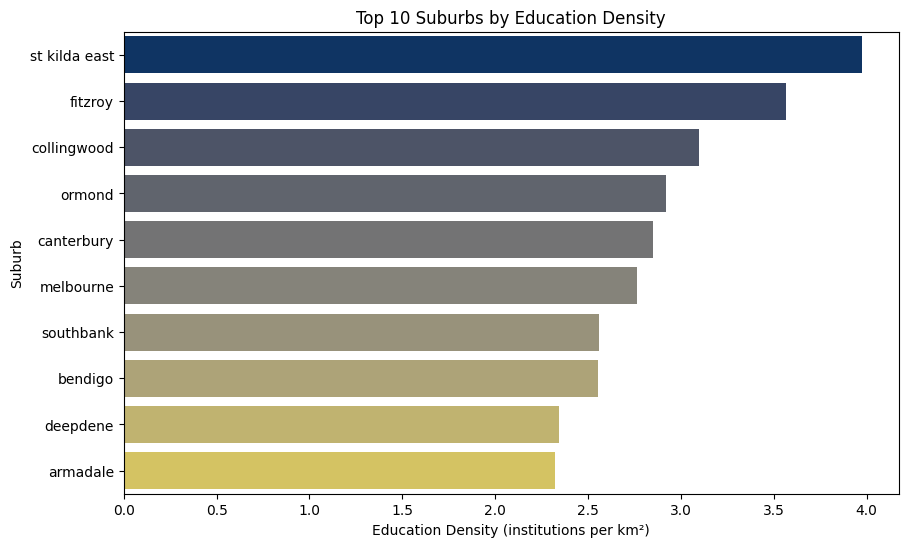

In [63]:
# Step 1: Sort the DataFrame by education density and select the top 10
top_10_suburbs = vic_education_gdf_projected.nlargest(10, 'education_density')

# Step 2: Create the bar plot for the top 10 suburbs
plt.figure(figsize=(10, 6))
sns.barplot(
    x='education_density', 
    y='suburb', 
    data=top_10_suburbs, 
    palette='cividis'
)
plt.title('Top 10 Suburbs by Education Density')
plt.xlabel('Education Density (institutions per km²)')
plt.ylabel('Suburb')

#plt.savefig('../plots/highest_education_density_suburbs.png', dpi=300, bbox_inches='tight')

plt.show()


/var/folders/06/j_x36p4x2c97zzkt3gr_g8f80000gn/T/ipykernel_43733/1670722753.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


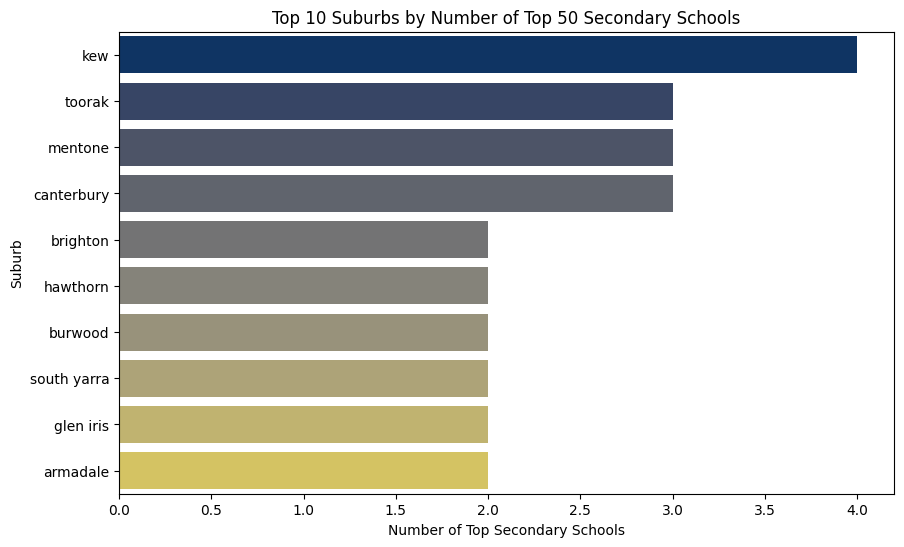

In [53]:
# Step 1: Filter the top 50 secondary schools by rank
top_50_secondary_schools = final_secondary_schools_df.nsmallest(50, 'rank')

# Step 2: Group by suburb and count the number of top schools in each suburb
suburb_counts = top_50_secondary_schools['suburb'].value_counts().reset_index()
suburb_counts.columns = ['suburb', 'top_school_count']

# Step 3: Sort and select the top 10 suburbs
top_10_suburbs = suburb_counts.nlargest(10, 'top_school_count')

# Step 4: Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='top_school_count',
    y='suburb',
    data=top_10_suburbs,
    palette='cividis'
)

plt.title('Top 10 Suburbs by Number of Top 50 Secondary Schools')
plt.xlabel('Number of Top Secondary Schools')
plt.ylabel('Suburb')

#plt.savefig('../plots/secondary_ed_top_suburbs.png', dpi=300, bbox_inches='tight')

plt.show()

In [12]:
# Step 1: Merge geographical data with education counts using an inner join
vic_education_gdf = vic_suburbs_filtered.merge(final_suburb_counts, on='suburb', how='inner')
# Convert 'total_education_count' to numeric
vic_education_gdf['total_education_count'] = pd.to_numeric(vic_education_gdf['total_education_count'], errors='coerce')
# Step 2: Reproject to a projected CRS for accurate area calculation (e.g., VICGRID94)
vic_education_gdf = vic_education_gdf.to_crs(epsg=3111)  # Use a projected CRS like VICGRID94
# Calculate the area in square kilometers (assuming your geometry is in meters)
vic_education_gdf['area_km2'] = vic_education_gdf['geometry'].area / 1e6
# Step 3: Calculate education density (counts of institutions per km²)
vic_education_gdf['education_density'] = vic_education_gdf['total_education_count'] / vic_education_gdf['area_km2']
# Transform back to a geographic CRS for visualization in Folium
vic_education_gdf = vic_education_gdf.to_crs(epsg=4326)

DO COUNTS INSTEAD

/var/folders/06/j_x36p4x2c97zzkt3gr_g8f80000gn/T/ipykernel_50309/74730096.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


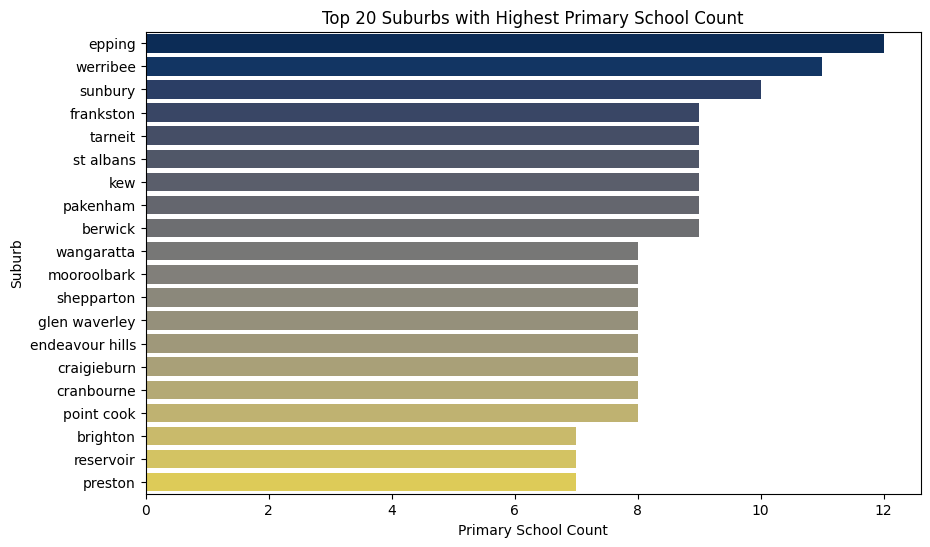

In [10]:
# Ensure 'primary_school_count' is numeric
vic_education_gdf['primary_school_count'] = pd.to_numeric(vic_education_gdf['primary_school_count'], errors='coerce').fillna(0)

# Ensure 'area_km2' is numeric
#vic_education_gdf['area_km2'] = pd.to_numeric(vic_education_gdf['area_km2'], errors='coerce').fillna(1)  # Use 1 to avoid division by zero

# Step 1: Calculate the primary school density for each suburb
#vic_education_gdf['primary_school_density'] = vic_education_gdf['primary_school_count'] / vic_education_gdf['area_km2']

# Step 2: Sort the suburbs by primary school density and select the top 20
top_20_primary_suburbs = vic_education_gdf.nlargest(20, 'primary_school_count')

# Step 3: Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='primary_school_count',
    y='suburb',
    data=top_20_primary_suburbs,
    palette='cividis'
)
plt.title('Top 20 Suburbs with Highest Primary School Count')
plt.xlabel('Primary School Count')
plt.ylabel('Suburb')

#plt.savefig('../plots/primary_ed_top_suburbs.png', dpi=300, bbox_inches='tight')

plt.show()

bar chart: top 20 suburbs based on education density, secondary school rank, primary school density

/var/folders/06/j_x36p4x2c97zzkt3gr_g8f80000gn/T/ipykernel_50309/3232493202.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/06/j_x36p4x2c97zzkt3gr_g8f80000gn/T/ipykernel_50309/3232493202.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/06/j_x36p4x2c97zzkt3gr_g8f80000gn/T/ipykernel_50309/3232493202.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


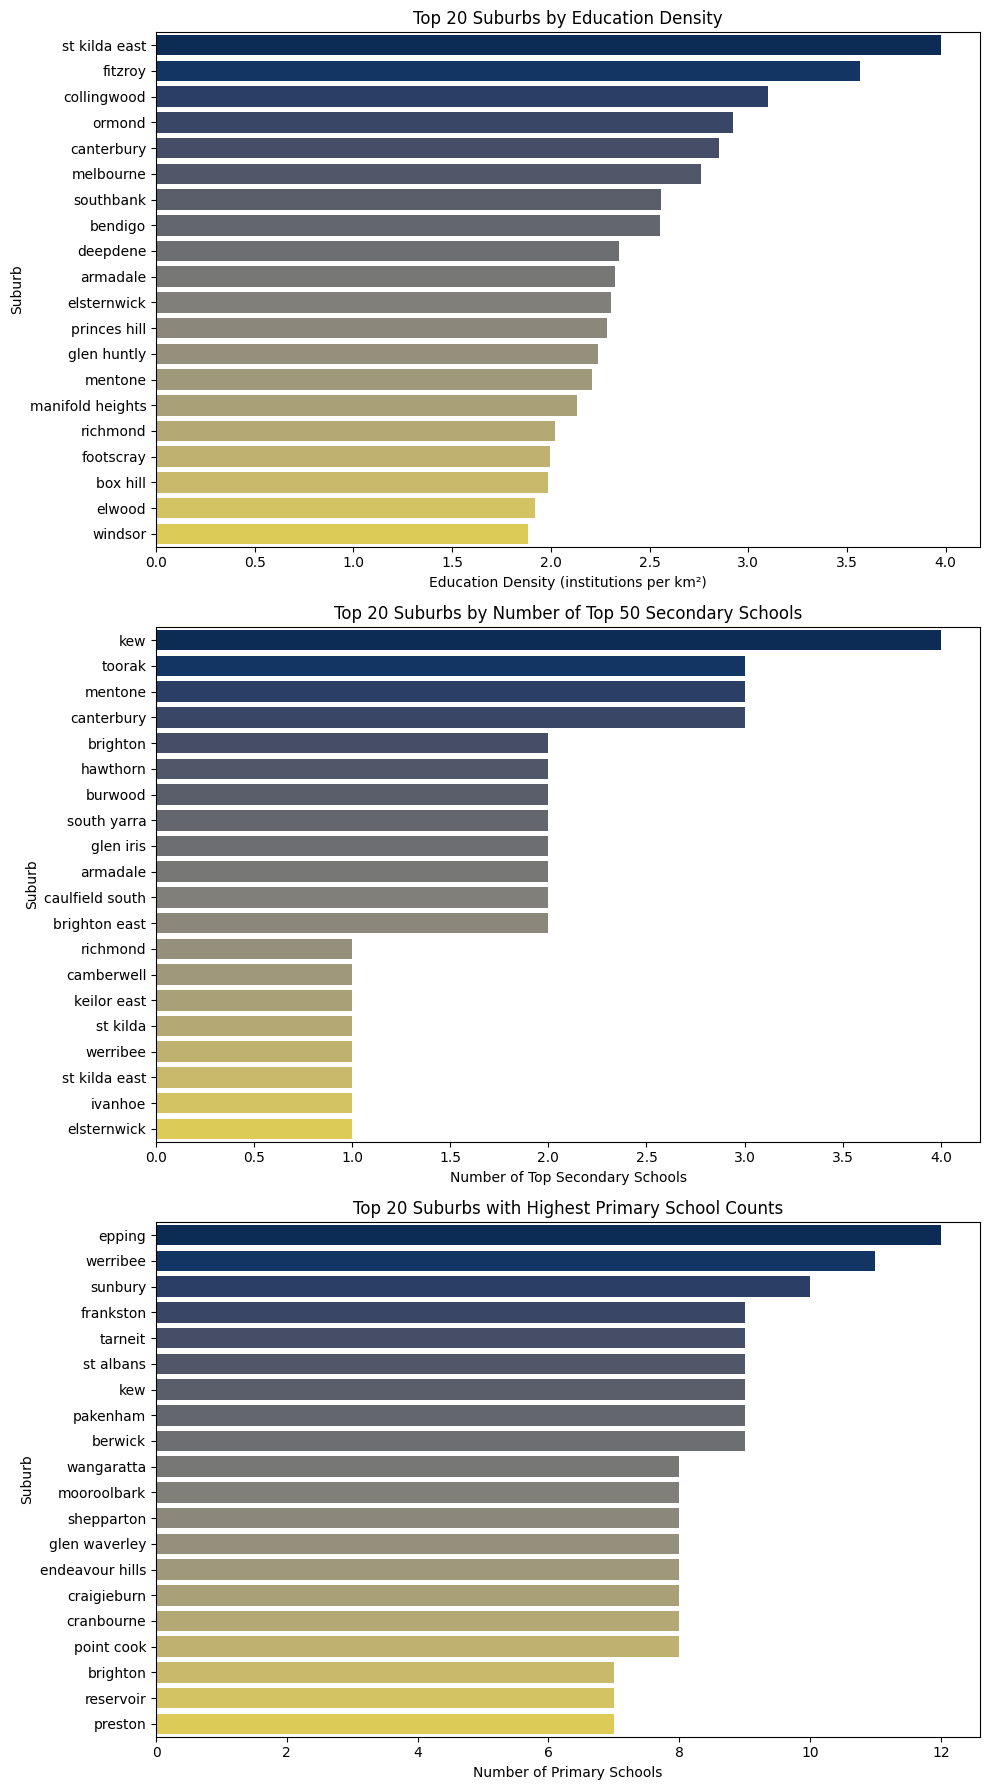

Suburbs appearing in all three plots: set()
Suburbs appearing in at least two plots: {'elsternwick', 'st kilda east', 'richmond', 'armadale', 'mentone', 'brighton', 'werribee', 'canterbury', 'kew'}


In [15]:
# Step 1: Create subplots for the three bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot 1: Top 20 Suburbs by Education Density
top_20_suburbs = vic_education_gdf.nlargest(20, 'education_density')
sns.barplot(
    x='education_density', 
    y='suburb', 
    data=top_20_suburbs, 
    palette='cividis',
    ax=axes[0]
)
axes[0].set_title('Top 20 Suburbs by Education Density')
axes[0].set_xlabel('Education Density (institutions per km²)')
axes[0].set_ylabel('Suburb')

# Plot 2: Top 20 Suburbs by Number of Top 50 Secondary Schools
top_50_secondary_schools = final_secondary_schools_df.nsmallest(50, 'rank')
suburb_counts = top_50_secondary_schools['suburb'].value_counts().reset_index()
suburb_counts.columns = ['suburb', 'top_school_count']
top_20_secondary_school_suburbs = suburb_counts.nlargest(20, 'top_school_count')
sns.barplot(
    x='top_school_count',
    y='suburb',
    data=top_20_secondary_school_suburbs,
    palette='cividis',
    ax=axes[1]
)
axes[1].set_title('Top 20 Suburbs by Number of Top 50 Secondary Schools')
axes[1].set_xlabel('Number of Top Secondary Schools')
axes[1].set_ylabel('Suburb')

# Plot 3: Top 20 Suburbs by Primary School Density
vic_education_gdf['primary_school_count'] = pd.to_numeric(vic_education_gdf['primary_school_count'], errors='coerce').fillna(0)
top_20_primary_suburbs = vic_education_gdf.nlargest(20, 'primary_school_count')
sns.barplot(
    x='primary_school_count',
    y='suburb',
    data=top_20_primary_suburbs,
    palette='cividis',
    ax=axes[2]
)
axes[2].set_title('Top 20 Suburbs with Highest Primary School Counts')
axes[2].set_xlabel('Number of Primary Schools')
axes[2].set_ylabel('Suburb')

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the combined plots as a single PNG file
plt.savefig('../plots/combined_education_20_suburb_plots.png', dpi=300, bbox_inches='tight')

# Display the plots
plt.show()

# Step 4: Identify overlaps between the three lists
set_education_density = set(top_20_suburbs['suburb'])
set_secondary_schools = set(top_20_secondary_school_suburbs['suburb'])
set_primary_school_counts = set(top_20_primary_suburbs['suburb'])

# Suburbs appearing in all three plots
all_three = set_education_density & set_secondary_schools & set_primary_school_counts

# Suburbs appearing in any two plots
in_two = (set_education_density & set_secondary_schools) | \
         (set_secondary_schools & set_primary_school_counts) | \
         (set_primary_school_counts & set_education_density)

print("Suburbs appearing in all three plots:", all_three)
print("Suburbs appearing in at least two plots:", in_two)

In [10]:
sample_properties = pd.read_csv('../data/landing/sample.csv')